# API

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
%load_ext line_profiler

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [79]:
# ipcluster start --engines=MPI
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from Chern_insulator import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [191]:
%%writefile Chern_insulator.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib


class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            t=1,
            Delta=1,
            m=1,
            bcx=1,
            bcy=-1,
            T=0,
            history=False):
        self.Lx = Lx
        self.Ly = Ly
        self.t = t
        self.Delta = Delta
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        hopx = np.diag(np.ones(Lx-1), -1)
        hopx[0, -1] = bcx
        hopy = np.diag(np.ones(Ly-1), -1)
        hopy[0, -1] = bcy
        hopxmat = np.kron(hopx, np.eye(Ly))
        hopymat = np.kron(np.eye(Lx), hopy)
        onsitemat = np.eye(Lx*Ly)
        self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay)) *
                            1j*t+Delta*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(
            self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = (occupancy_mat*self.vec)@self.vec.T.conj()

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max(
        ) < 1e-10, "Covariance matrix not real"
        self.Gamma=Gamma
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False):
        '''
        If proj ==True, then the index used for projection operator will be returned
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        X, Y = np.meshgrid(subregion_x, subregion_y)
        linear_index = ((X*self.Ly+Y).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, 2)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C'):
            self.covariance_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        return np.real(eA+sA)

    def projection(self, s):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
        blkmat = np.array([[0, -(-1)**s, 0, 0],
                           [(-1)**s, 0, 0, 0],
                           [0, 0, 0, (-1)**s],
                           [0, 0, -(-1)**s, 0]])
        return blkmat

    def measure(self, s, ix):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(i)
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [i]

    def measure_all_Born(self, proj_range,P_0=None):
        proj_range = self.linearize_index(proj_range, 4, proj=True)
        self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.covariance_matrix()
        for i in proj_range:
            if P_0 is None:
                P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
            self.P_0_list.append(P_0)
            if np.random.rand() < P_0:
                self.measure(0, [i, i+1])
            else:
                self.measure(1, [i, i+1])
        return self

Overwriting Chern_insulator.py


# Test

In [171]:
params=Params(Lx=4,Ly=4)

In [172]:
params.covariance_matrix()

In [173]:
np.imag(params.C_f)

array([[ 0.00000000e+00, -1.06631720e-17, -1.81905318e-17, ...,
         1.16270651e-18, -1.99908862e-17, -2.81199872e-02],
       [ 1.06631720e-17,  0.00000000e+00,  1.06251813e-16, ...,
        -2.08166817e-17, -2.81199872e-02, -5.20417043e-17],
       [ 1.81905318e-17, -1.06251813e-16,  0.00000000e+00, ...,
         2.81199872e-02, -3.29597460e-17, -1.18828558e-16],
       ...,
       [-1.16270651e-18,  2.08166817e-17, -2.81199872e-02, ...,
         0.00000000e+00, -2.77555756e-17,  1.38777878e-17],
       [ 1.99908862e-17,  2.81199872e-02,  3.29597460e-17, ...,
         2.42861287e-17,  0.00000000e+00,  1.38777878e-17],
       [ 2.81199872e-02,  6.24500451e-17,  1.15359111e-16, ...,
        -1.04083409e-17, -1.38777878e-17,  0.00000000e+00]])

In [174]:
print(np.round(np.real(params.Gamma),2)[:8,:8])

[[ 0.    0.49  0.    0.    0.    0.24 -0.   -0.35]
 [-0.49  0.   -0.    0.   -0.24  0.    0.35 -0.  ]
 [-0.    0.    0.   -0.49 -0.    0.35  0.   -0.24]
 [-0.   -0.    0.49  0.   -0.35 -0.    0.24  0.  ]
 [-0.    0.24  0.    0.35  0.    0.49 -0.   -0.  ]
 [-0.24 -0.   -0.35  0.   -0.49  0.    0.   -0.  ]
 [ 0.   -0.35  0.   -0.24  0.   -0.    0.   -0.49]
 [ 0.35  0.    0.24  0.    0.    0.    0.49  0.  ]]


In [175]:
print(np.round(np.real(params.C_m@params.C_m),2)[:8,:8])

[[-1. -0. -0.  0. -0. -0.  0.  0.]
 [-0. -1. -0. -0.  0. -0. -0.  0.]
 [-0. -0. -1.  0. -0.  0. -0.  0.]
 [ 0. -0.  0. -1. -0. -0. -0. -0.]
 [-0.  0. -0. -0. -1.  0. -0.  0.]
 [-0. -0.  0. -0.  0. -1. -0. -0.]
 [ 0. -0. -0. -0. -0. -0. -1. -0.]
 [ 0.  0.  0. -0.  0. -0. -0. -1.]]


In [ ]:
params.G_m@param

In [120]:
np.round(params.C_m[:6,:6],4)

array([[ 0.    ,  0.4919,  0.    ,  0.    ,  0.    ,  0.2355],
       [-0.4919,  0.    , -0.    ,  0.    , -0.2355,  0.    ],
       [ 0.    ,  0.    ,  0.    , -0.4919,  0.    ,  0.3485],
       [-0.    ,  0.    ,  0.4919,  0.    , -0.3485,  0.    ],
       [ 0.    ,  0.2355,  0.    ,  0.3485,  0.    ,  0.4919],
       [-0.2355,  0.    , -0.3485,  0.    , -0.4919,  0.    ]])

In [102]:
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],0)

In [100]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.09799924560617868

In [105]:
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],1)

In [107]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.09799924560604012

In [ ]:
params.P_0_list

0.09799924560617868

In [308]:
params.m

1

In [244]:
params.von_Neumann_entropy_f([[0,1],np.arange(params.Ly)])

18.21804687416391

In [245]:
params.von_Neumann_entropy_m([[0,1],np.arange(params.Ly)])

18.21804687416391

In [249]:
params.mutual_information_f([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752372978

In [250]:
params.mutual_information_m([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752373198

In [267]:
params.log_neg([[0,1],np.arange(params.Ly)],[[16,17],np.arange(params.Ly)])

9.035083792241494e-11

In [178]:
m_list=np.linspace(0,3)
eigvallist=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=1,Lx=16,Ly=16,Delta=0.5)
    params.bandstructure()
    eigvallist.append(params.val)


In [179]:
func=lambda kx,ky,m,t,Delta:np.sqrt((t*np.sin(kx))**2+(t*np.sin(ky))**2+(m-Delta*np.cos(kx)-Delta*np.cos(ky))**2)

In [180]:
KX,KY=np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(-np.pi,np.pi))

In [181]:
en_max=[]
en_min=[]
for m in m_list:
    en=func(KX,KY,m,1,0.5)
    en_max.append(en.max())
    en_min.append(en.min())

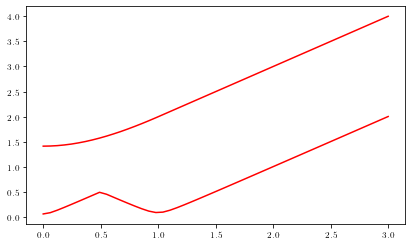

In [183]:
plt.plot(m_list,en_min,'r')
plt.plot(m_list,en_max,'r')

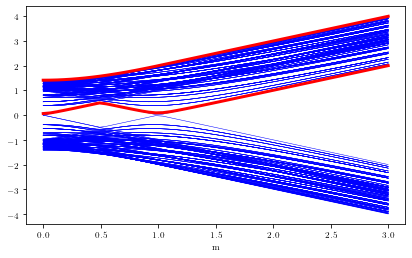

In [185]:
plt.plot(m_list,eigvallist,'b',lw=0.5)
plt.xlabel(r'm')
plt.plot(m_list,en_min,'r',lw=3)
plt.plot(m_list,en_max,'r',lw=3)

# plt.ylim([-.5,.5])

# No measurement

In [176]:
m_list=np.linspace(1,3,20)
LN_no_list=[]
MI_no_list=[]
for m in m_list:
    params=Params(m=m,Lx=16,Ly=8)
    # MI_no_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN_no_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


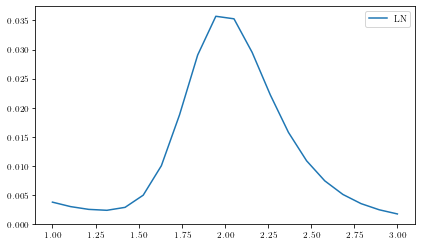

In [177]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list,label='LN')
# ax.plot(m_list,MI_no_list,label='MI')
ax.legend()

# Measure to 0

In [178]:
m_list=np.linspace(1,3,20)
es=1
LN_empty_list=np.zeros((len(m_list),es))
MI_empty_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    # st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0)
        # MI_empty_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_empty_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_empty_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


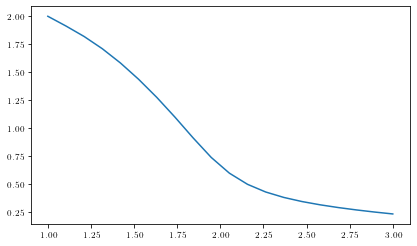

In [180]:
plt.plot(m_list,LN_empty_list)

# Measure to 0.5

In [81]:
m_list=np.linspace(1,3,20)
es=50
LN_half_list=np.zeros((len(m_list),es))
MI_half_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    # params0=Params(m=m,Lx=16,Ly=8)
    # for es_i in range(es):
        # params=copy(params0)
        # params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0.5)
        # # MI_half_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        # LN_half_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])],0.5).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    LN_half_list[m_i,:]=async_result 

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:8.2
1:7.4
2:7.5
3:7.3
4:7.9
5:7.4
6:7.6
7:7.6
8:7.1
9:7.7
10:8.1
11:7.6
12:7.5
13:7.0
14:6.7
15:7.3
16:7.5
17:7.6
18:7.4
19:7.5


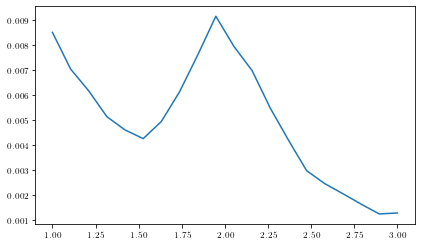

In [87]:
plt.plot(m_list,LN_half_list.mean(axis=1))
# plt.plot(m_list,LN_empty_list)

# Measure to 1

In [182]:
m_list=np.linspace(1,3,20)
es=1
LN_occ_list=np.zeros((len(m_list),es))
MI_occ_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],1)
        # MI_occ_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_occ_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_occ_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


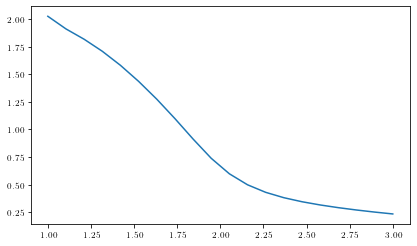

In [184]:
plt.plot(m_list,LN_occ_list)
# plt.plot(m_list,LN_empty_list)

# Born measurement

In [187]:
m_list=np.linspace(1,3,20)
es=10
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=16,Ly=8)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
        # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_Born_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_Born_list[m_i,:]=async_result 

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:11.3
1:11.2
2:10.5
3:10.8
4:13.4
5:11.8
6:13.8
7:12.9
8:12.0
9:11.5
10:11.4
11:12.9
12:13.9
13:14.0
14:13.1
15:15.5
16:13.9
17:14.0
18:13.8
19:14.2


In [83]:
with open('/mnt/d/KITP/Rp_SPT/8/MI_LN_CI_Born_En100_Lx16_Ly16.pickle','rb') as f:
    [m_list,MI_Born_list,LN_Born_list,MI_no_list,LN_no_list]=pickle.load(f)

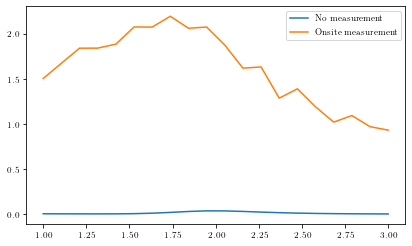

In [190]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list,label='No measurement')
ax.plot(m_list,LN_Born_list.mean(axis=1),label='Onsite measurement')
# ax.plot(m_list,MI_Born_list.mean(axis=1),label='MI')
ax.legend()

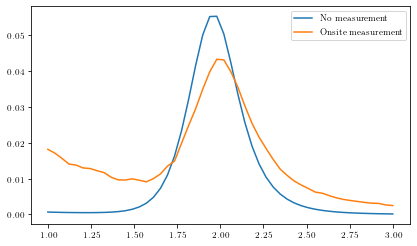

In [84]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list,label='No measurement')
ax.plot(m_list,LN_Born_list.mean(axis=1),label='Onsite measurement')
# ax.plot(m_list,MI_Born_list.mean(axis=1),label='MI')
ax.legend()

# Check area law of EE

In [77]:
EE_list={}

In [78]:
l_EE_list=np.arange(2,32)
for Ly in (8,12,16):
    params=Params(m=1,Lx=32,Ly=Ly)
    EE_list[Ly]=[(params.von_Neumann_entropy_f([np.arange(l),np.arange(params.Ly)])) for l in l_EE_list]


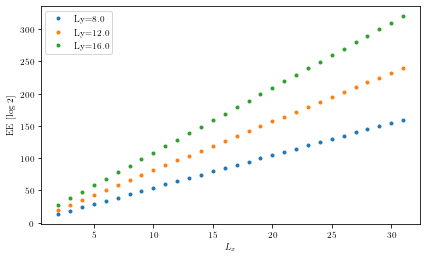

In [79]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

# LN scaling behavior

In [92]:
LN_scaling_list={}

In [83]:
l_LN_list=np.arange(2,16)
for Ly in (8,12,16):
    params=Params(m=1,Lx=32,Ly=Ly)
    LN_scaling_list[Ly]=[params.log_neg([np.arange(l),np.arange(params.Ly)],[np.arange(l)+l,np.arange(params.Ly)]) for l in l_LN_list]


In [94]:
l_LN_list=np.arange(2,16)
for Ly in (8,12,16):
    LN_scaling_list[Ly]=[]
    for Lx in l_LN_list:
        params=Params(m=1,Lx=2*Lx,Ly=Ly)
        LN_scaling_list[Ly].append(params.log_neg([np.arange(Lx),np.arange(params.Ly)],[np.arange(Lx)+Lx,np.arange(params.Ly)]))

Text(0, 0.5, 'Log neg [log 2]')

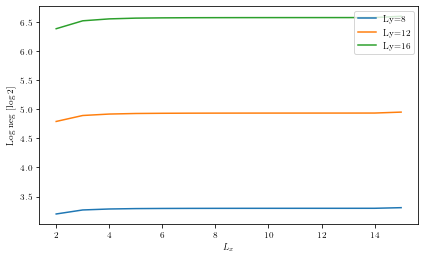

In [84]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

Text(0, 0.5, 'Log neg [log 2]')

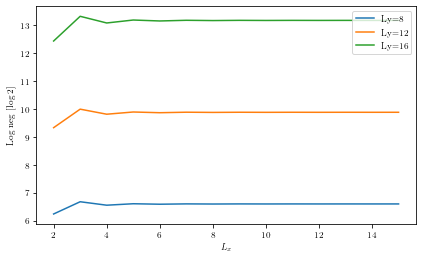

In [95]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

# profiler

In [22]:
params=Params(Lx=32,Ly=16,history=False)

In [33]:
def test(A):
    return A+A.T

In [34]:
z=np.random.rand(2048,2048)

In [35]:
%lprun -f test test(z)

Timer unit: 1e-06 s

Total time: 0.072097 s
File: <ipython-input-33-b33413829b27>
Function: test at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test(A):
     2         1      72097.0  72097.0    100.0      return A+A.T

In [37]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-36-933e8321812b>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264                                                   if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266                                                   if not hasattr(self, 's_history'):
   267                                                       self.s_history = []
   268                                                   if not hasattr(self, 'i_history'):
   269                                                       self.i_history = []
   270                                           
   271                                                   mat = self.C_m_history[-1].copy()
   272                                           
   273                                     

In [23]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 29.93 s
File: <ipython-input-20-6f8c91c52c07>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264       256       1244.0      4.9      0.0          if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266       256        532.0      2.1      0.0          if not hasattr(self, 's_history'):
   267         1          1.0      1.0      0.0              self.s_history = []
   268       256        510.0      2.0      0.0          if not hasattr(self, 'i_history'):
   269         1          1.0      1.0      0.0              self.i_history = []
   270                                           
   271       256    2002997.0   7824.2      6.7          mat = self.C_m_history[-1].copy()
   272                                           
   273       768       4359.0      5.7 

In [12]:
%lprun -f Params.bandstructure params.covariance_matrix()

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-9-f4caf49fbcb7>
Function: bandstructure at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def bandstructure(self):
    41                                                   val, vec = nla.eigh(self.Hamiltonian)
    42                                                   sortindex = np.argsort(val)
    43                                                   self.val = val[sortindex]
    44                                                   self.vec = vec[:, sortindex]

In [343]:
%lprun -f Params.c_subregion_m params.c_subregion_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094403 s
File: <ipython-input-310-09246d8612a9>
Function: c_subregion_m at line 146

Line #      Hits         Time  Per Hit   % Time  Line Contents
   146                                               def c_subregion_m(self, subregion, Gamma=None):
   147                                                   '''
   148                                                   subregion: [subregoin_x, subregion_y] index of unit cell
   149                                                   '''
   150         1          2.0      2.0      0.0          if not hasattr(self, 'C_m'):
   151         1      93460.0  93460.0     99.0              self.covariance_matrix()
   152         1          3.0      3.0      0.0          if Gamma is None:
   153         1          2.0      2.0      0.0              Gamma = self.C_m_history[-1]
   154         1          1.0      1.0      0.0          try:
   155         1          5.0      5.0      0.0              subregion = list(sub

In [334]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.11278 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1     107655.0 107655.0     95.5          c_A = self.c_subregion_m(subregion)
   185         1       4908.0   4908.0      4.4          val = nla.eigvalsh(1j*c_A)
   186         1          4.0      4.0      0.0          self.val_sh = val
   187         1         41.0     41.0      0.0          val = np.sort(val)
   188         1         31.0     31.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        141.0    141.0      0.1          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [335]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094029 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1      88525.0  88525.0     94.1          c_A = self.c_subregion_m(subregion)
   185         1       5259.0   5259.0      5.6          val = nla.eigvalsh(1j*c_A)
   186         1          3.0      3.0      0.0          self.val_sh = val
   187         1         37.0     37.0      0.0          val = np.sort(val)
   188         1         47.0     47.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        158.0    158.0      0.2          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [340]:
%lprun -f Params.mutual_information_m params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.037132 s
File: <ipython-input-310-09246d8612a9>
Function: mutual_information_m at line 202

Line #      Hits         Time  Per Hit   % Time  Line Contents
   202                                               def mutual_information_m(self, subregion_A, subregion_B):
   203         1        686.0    686.0      1.8          subregion_A=self.linearize_index(subregion_A,4)
   204         1        407.0    407.0      1.1          subregion_B=self.linearize_index(subregion_B,4)
   205         3        578.0    192.7      1.6          assert np.intersect1d(
   206         2          2.0      1.0      0.0              subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
   207         1       5964.0   5964.0     16.1          s_A = self.von_Neumann_entropy_m(subregion_A)
   208         1       5543.0   5543.0     14.9          s_B = self.von_Neumann_entropy_m(subregion_B)
   209         1        147.0    147.0      0.4          subregion_AB=np.conc

In [331]:
%lprun -f Params.log_neg Params(m=m,Lx=16,Ly=16).log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.202006 s
File: <ipython-input-310-09246d8612a9>
Function: log_neg at line 213

Line #      Hits         Time  Per Hit   % Time  Line Contents
   213                                               def log_neg(self,subregion_A,subregion_B,Gamma=None):
   214         1        333.0    333.0      0.2          subregion_A=self.linearize_index(subregion_A,4)
   215         1        155.0    155.0      0.1          subregion_B=self.linearize_index(subregion_B,4)
   216         1        155.0    155.0      0.1          assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
   217         1          2.0      2.0      0.0          if not hasattr(self,'C_m'):
   218         1      87192.0  87192.0     43.2              self.covariance_matrix()
   219                                                   
   220         1          3.0      3.0      0.0          if Gamma is None:
   221         1          3.0      3.0      0.0             

In [ ]:
# Check scaling behavior